In [2]:
!pip install rasterio

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 23.0/23.0 MB 2.4 MB/s eta 0:00:00
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
  Using cached affine-2.4.0-py3-none-any.whl (15 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import numpy as np
from PIL import Image
from skimage import draw
import random
from pathlib import Path
from rasterio import features

def create_image(path, img_size, min_radius):
    path.parent.mkdir(parents=True, exist_ok=True)

    arr = np.zeros((img_size, img_size)).astype(np.uint8)
    center_x = random.randint(min_radius, (img_size - min_radius))
    center_y = random.randint(min_radius, (img_size - min_radius))
    max_radius = min(center_x, center_y, img_size - center_x, img_size - center_y)
    radius = random.randint(min_radius, max_radius)

    row_indxs, column_idxs = draw.ellipse(center_x, center_y, radius, radius, shape=arr.shape)

    arr[row_indxs, column_idxs] = 255

    im = Image.fromarray(arr)
    im.save(path)


def create_images(data_root_path, train_num, val_num, test_num, img_size=640, min_radius=10):
    data_root_path = Path(data_root_path)

    for i in range(train_num):
        create_image(data_root_path / 'train' / 'images' / f'img_{i}.png', img_size, min_radius)

    for i in range(val_num):
        create_image(data_root_path / 'val' / 'images' / f'img_{i}.png', img_size, min_radius)

    for i in range(test_num):
        create_image(data_root_path / 'test' / 'images' / f'img_{i}.png', img_size, min_radius)


create_images('datasets', train_num=120, val_num=40, test_num=40, img_size=120, min_radius=10)


In [4]:

def create_label(image_path, label_path):
    arr = np.asarray(Image.open(image_path))

    # There may be a better way to do it, but this is what I have found so far
    cords = list(features.shapes(arr, mask=(arr >0)))[0][0]['coordinates'][0]
    label_line = '0 ' + ' '.join([f'{int(cord[0])/arr.shape[0]} {int(cord[1])/arr.shape[1]}' for cord in cords])

    label_path.parent.mkdir(parents=True, exist_ok=True )
    with label_path.open('w') as f:
        f.write(label_line)

for images_dir_path in [Path(f'datasets/{x}/images') for x in ['train', 'val', 'test']]:
    for img_path in images_dir_path.iterdir():
        label_path = img_path.parent.parent / 'labels' / f'{img_path.stem}.txt'
        label_line = create_label(img_path, label_path)


In [5]:
yaml_content = f'''
train: train/images
val: val/images
test: test/images

names: ['circle']
    '''

with Path('data.yaml').open('w') as f:
    f.write(yaml_content)

In [8]:
!tree .

Folder PATH listing
Volume serial number is 70A6-207B
C:\USERS\AREEB\NOTEBOOKS
+---.ipynb_checkpoints
+---datasets
    +---test
    ¦   +---images
    ¦   +---labels
    +---train
    ¦   +---images
    ¦   +---labels
    +---val
        +---images
        +---labels


In [9]:
!pip install ultralytics==8.0.38

Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------ 278.1/278.1 kB 408.3 kB/s eta 0:00:00
  Using cached wheel-0.41.0-py3-none-any.whl (64 kB)
     -------------------------------------- 904.2/904.2 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.0.20
    Uninstalling ultralytics-8.0.20:
      Successfully uninstalled ultralytics-8.0.20


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.56.0 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [10]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")

results = model.train(
        batch=8,
        device="cpu",
        data="data.yaml",
        epochs=7,
        imgsz=120,
    )

WARNING  Ultralytics settings reset to defaults. This is normal and may be due to a recent ultralytics package update, but may have overwritten previous settings. 
View and update settings with 'yolo settings' or at 'C:\Users\areeb\AppData\Roaming\Ultralytics\settings.yaml'
100%|█████████████████████████████████████████████████████████████████████████████| 6.73M/6.73M [00:02<00:00, 2.45MB/s]
Ultralytics YOLOv8.0.38  Python-3.9.13 torch-2.0.0+cpu CPU
yolo\engine\trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=data.yaml, epochs=7, patience=50, batch=8, imgsz=120, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
        6/7         0G     0.6095     0.3294      0.836      0.876         18        128: 100%|██████████| 15/15 [00:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP
                   all         40         40      0.979       0.95      0.993      0.861      0.979       0.95      0.993      0.729

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
        7/7         0G     0.5727     0.3322     0.7928     0.8919         11        128: 100%|██████████| 15/15 [00:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP
                   all         40         40          1      0.998      0.995      0.868          1      0.998      0.995      0.747

7 epochs completed in 0.035 hours.
Optimizer stripped from runs\segment\t

In [ ]:
Results saved to runs\segment\train

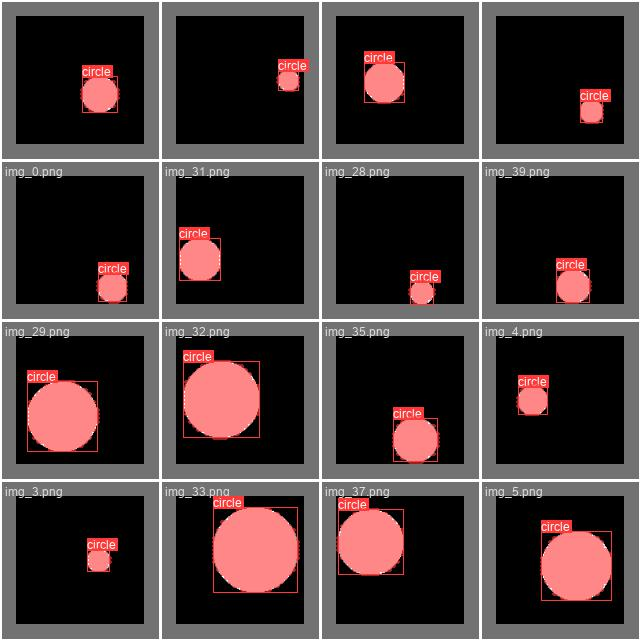

In [11]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train/val_batch0_labels.jpg")

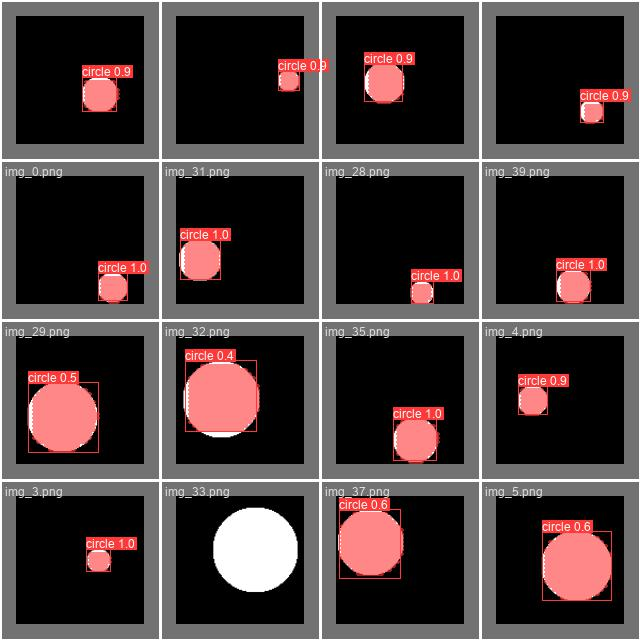

In [12]:
show_image(filename="runs/segment/train/val_batch0_pred.jpg")

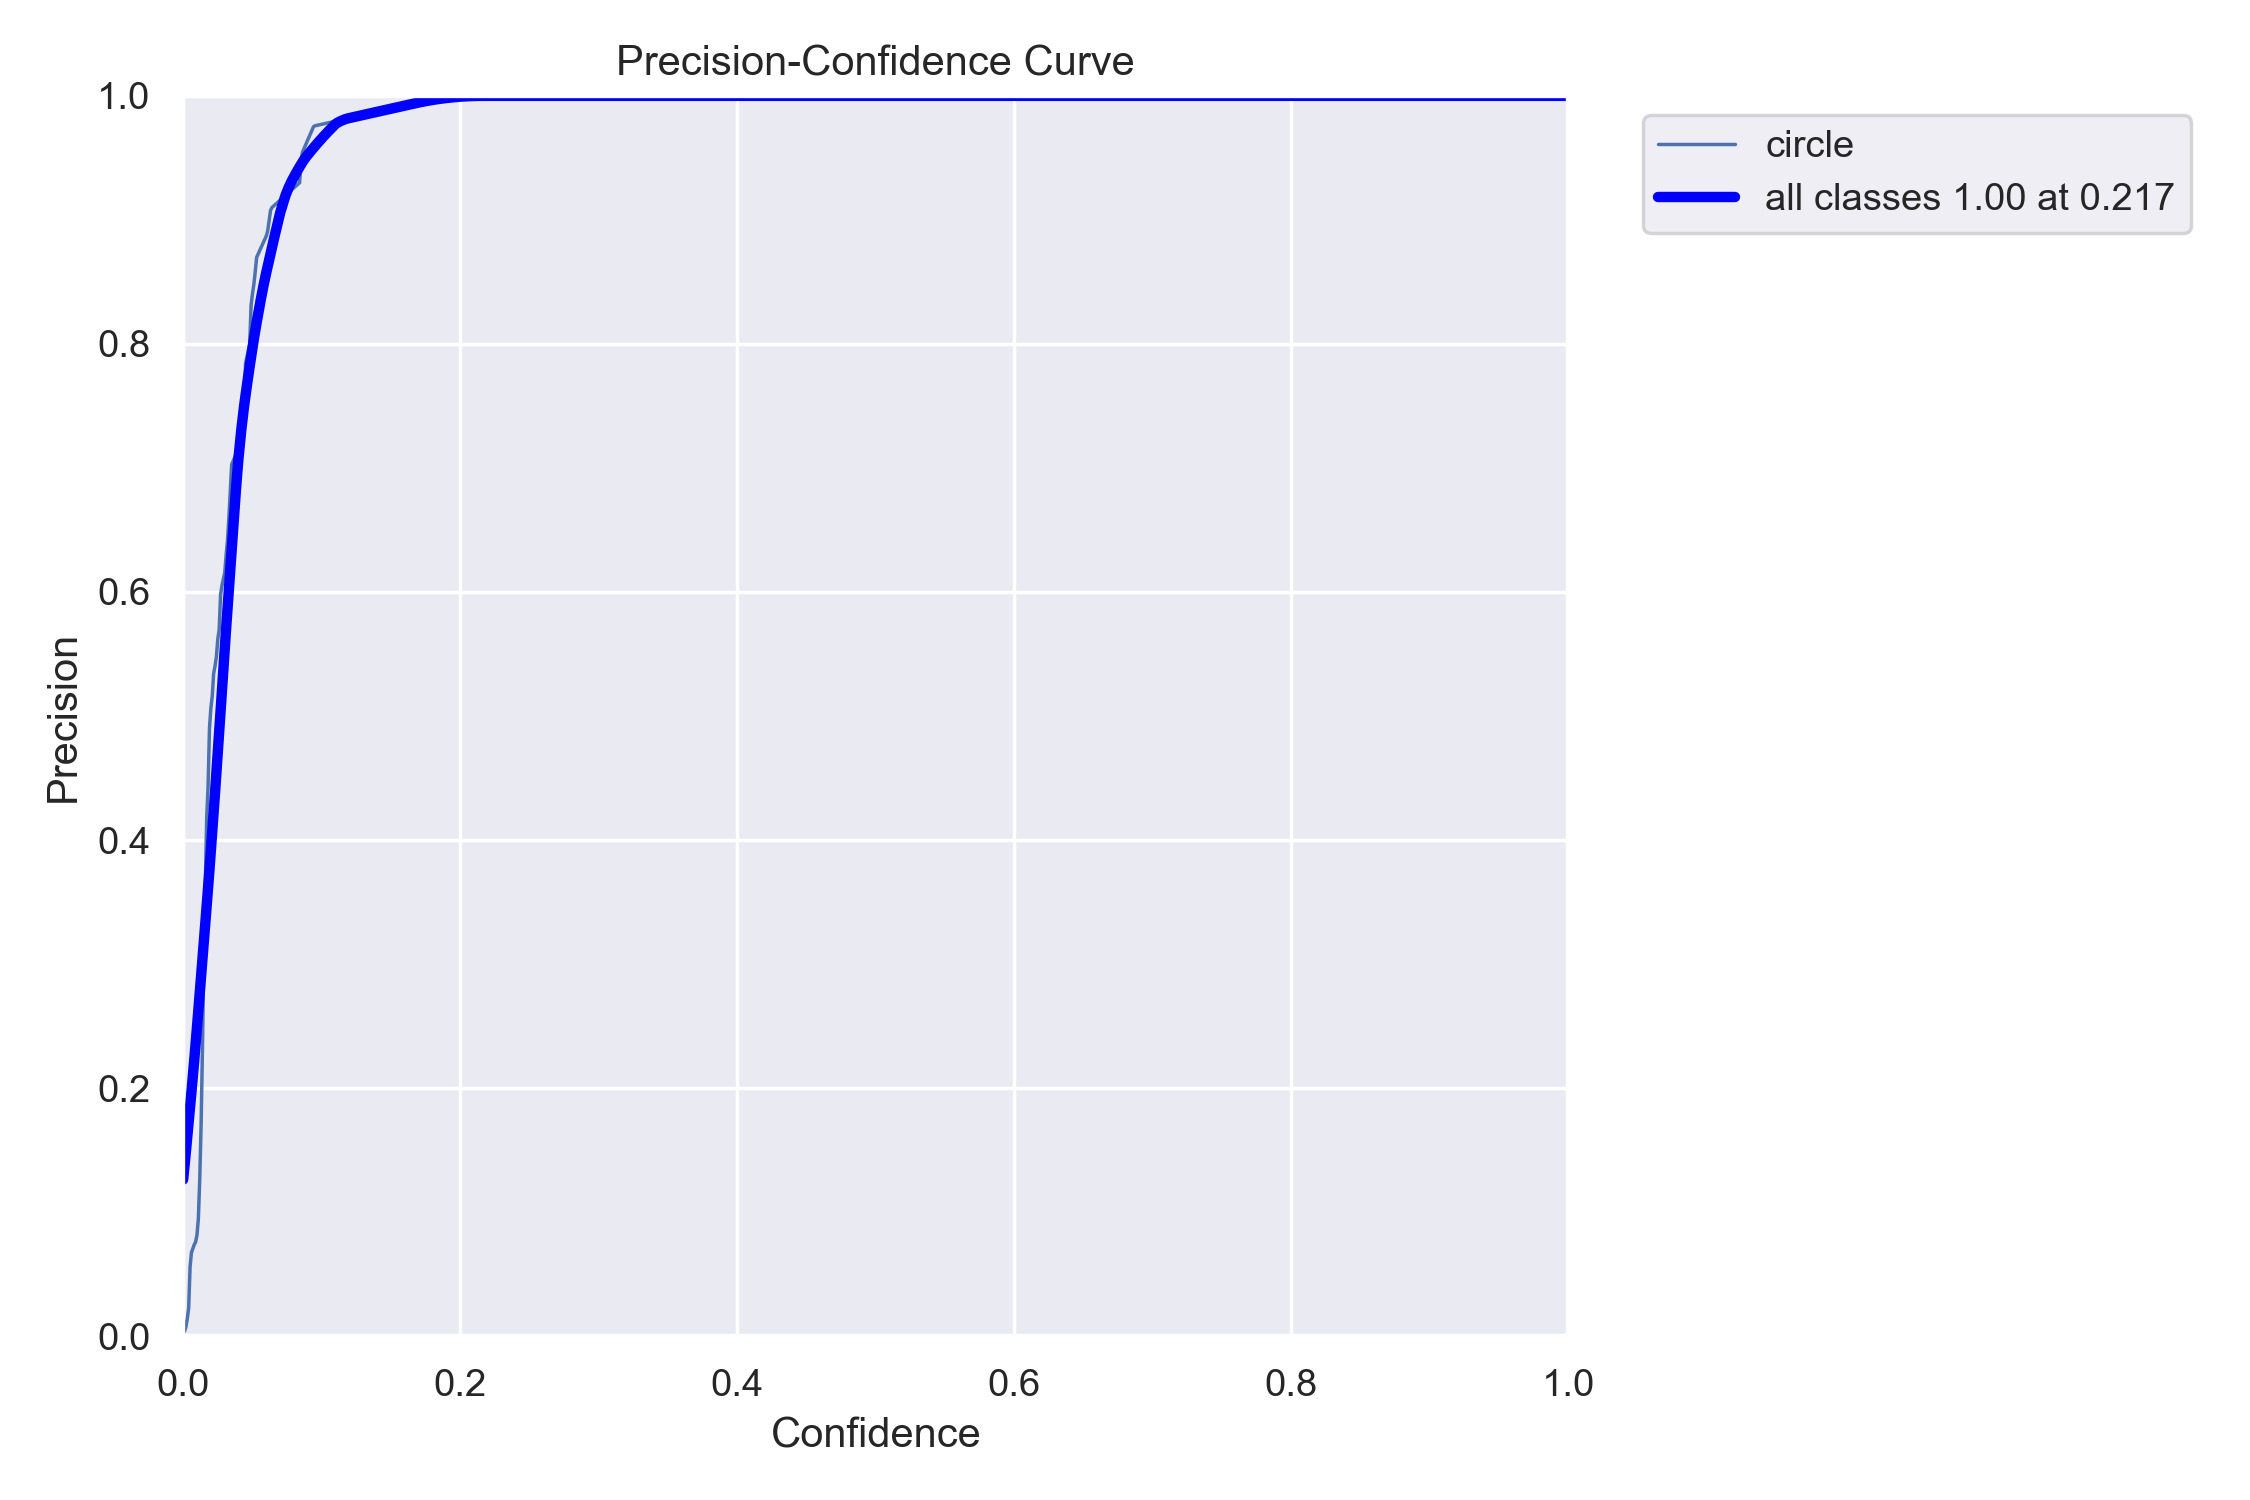

In [13]:
show_image(filename="runs/segment/train/MaskP_curve.png")

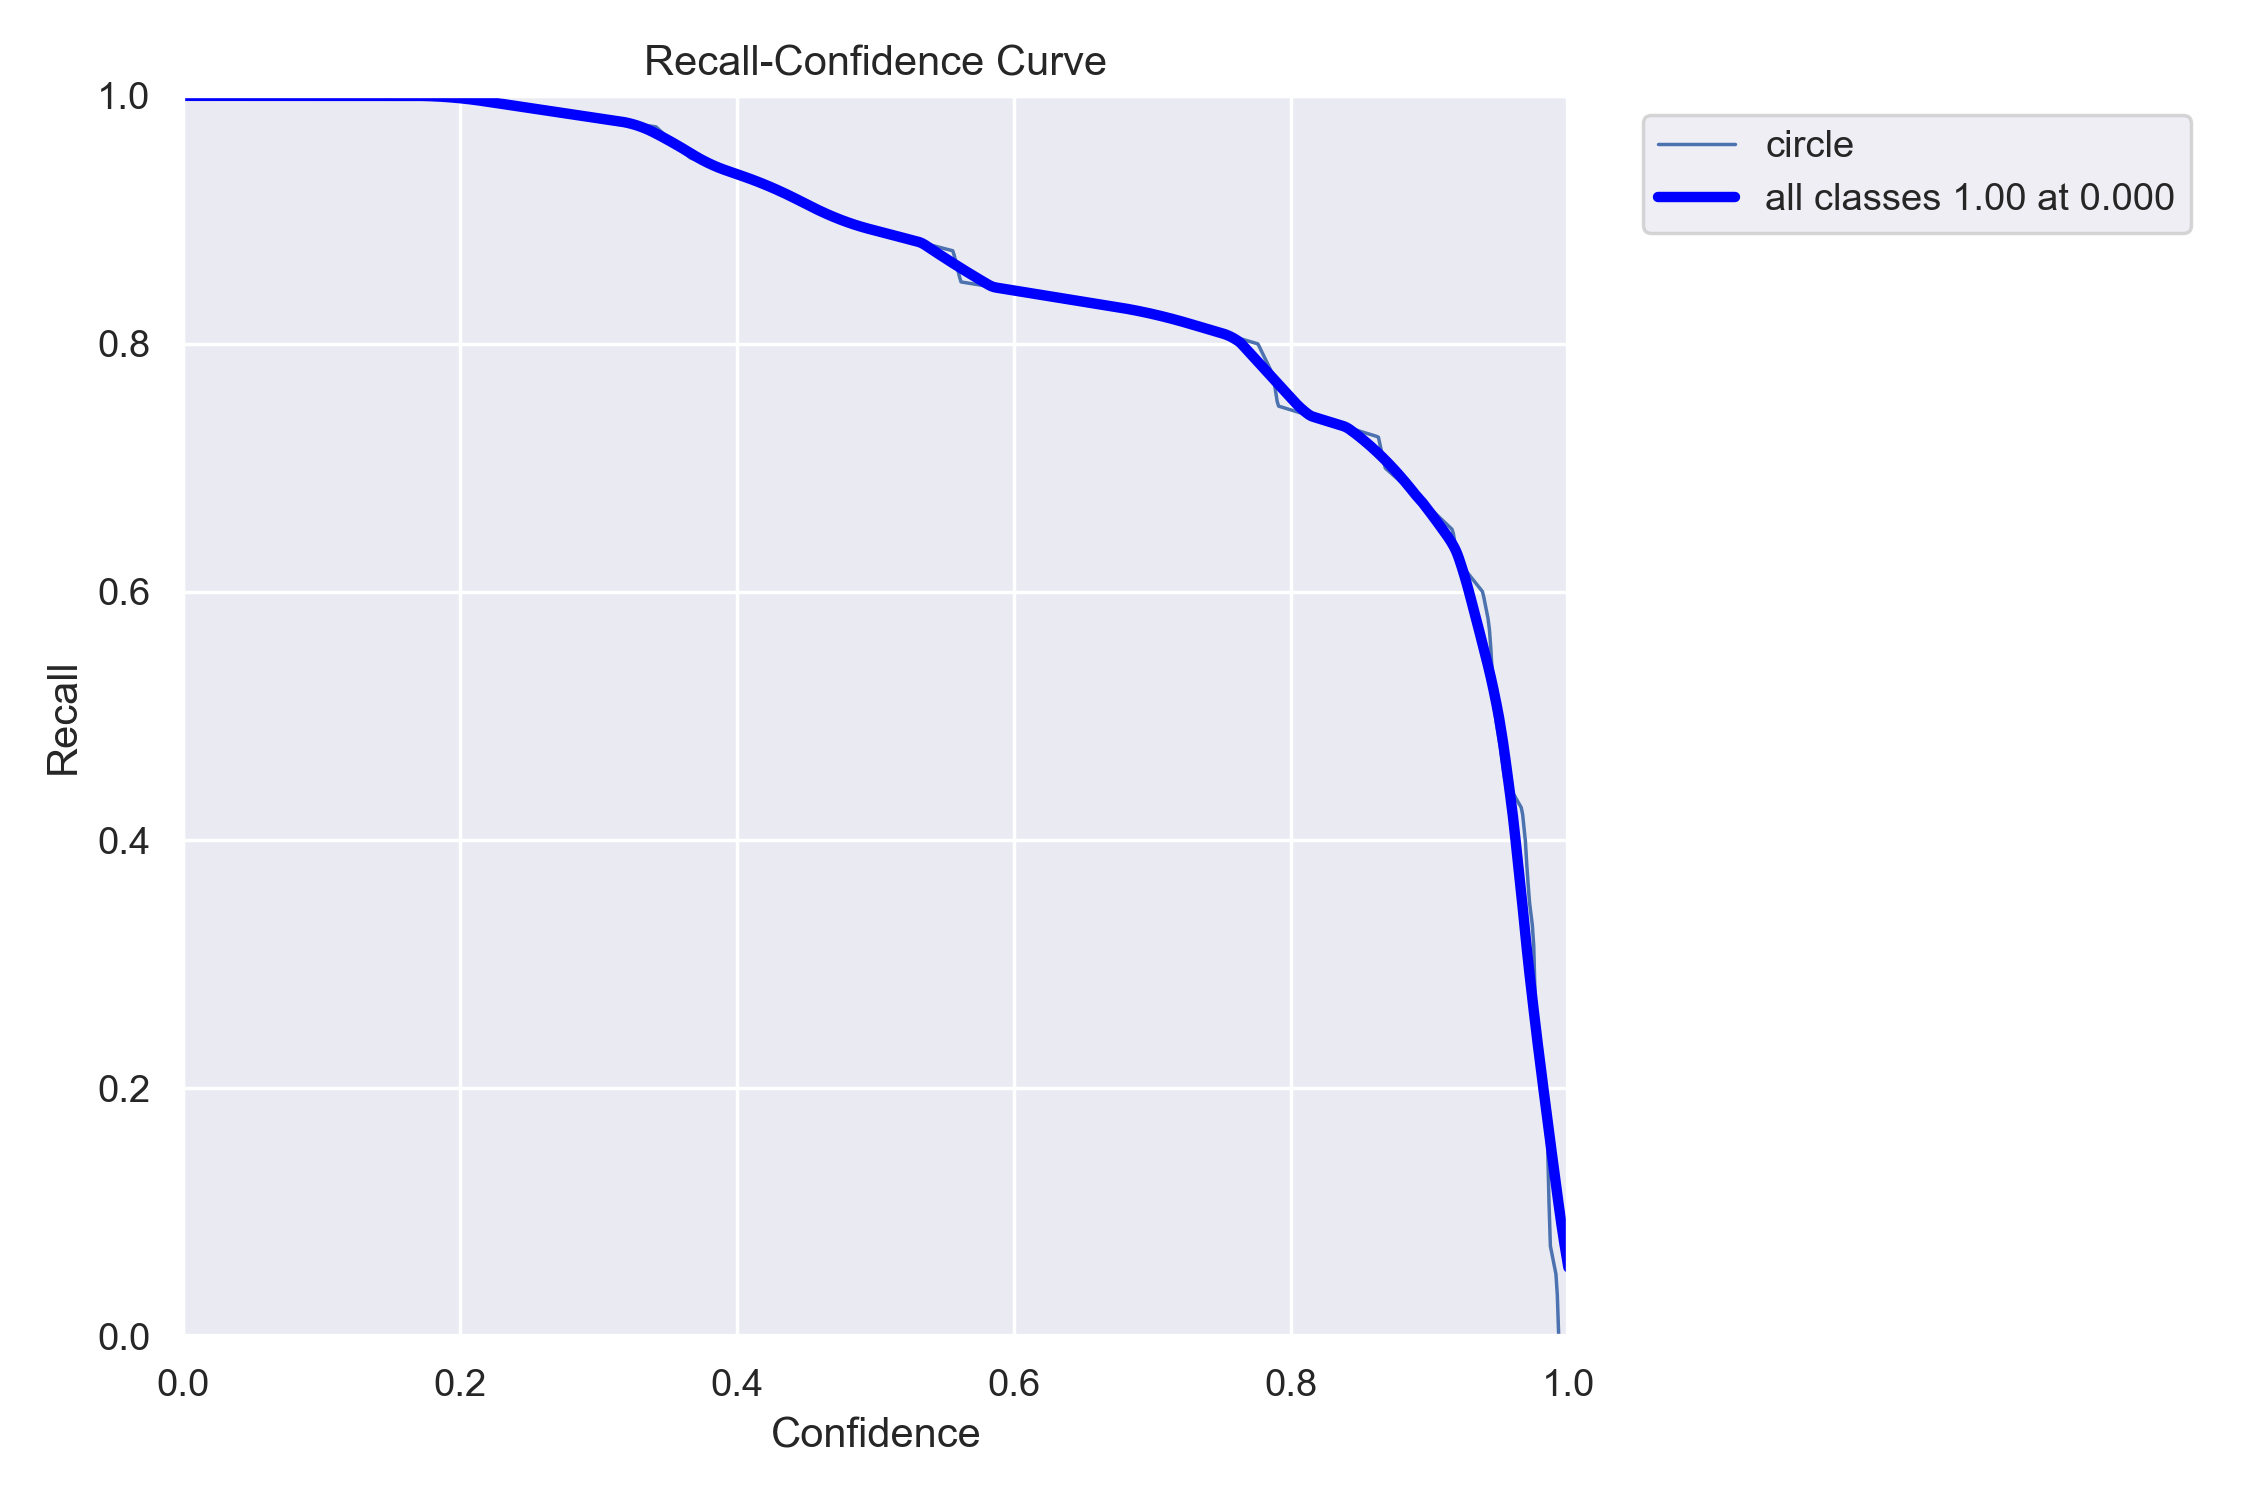

In [14]:
show_image(filename="runs/segment/train/MaskR_curve.png")

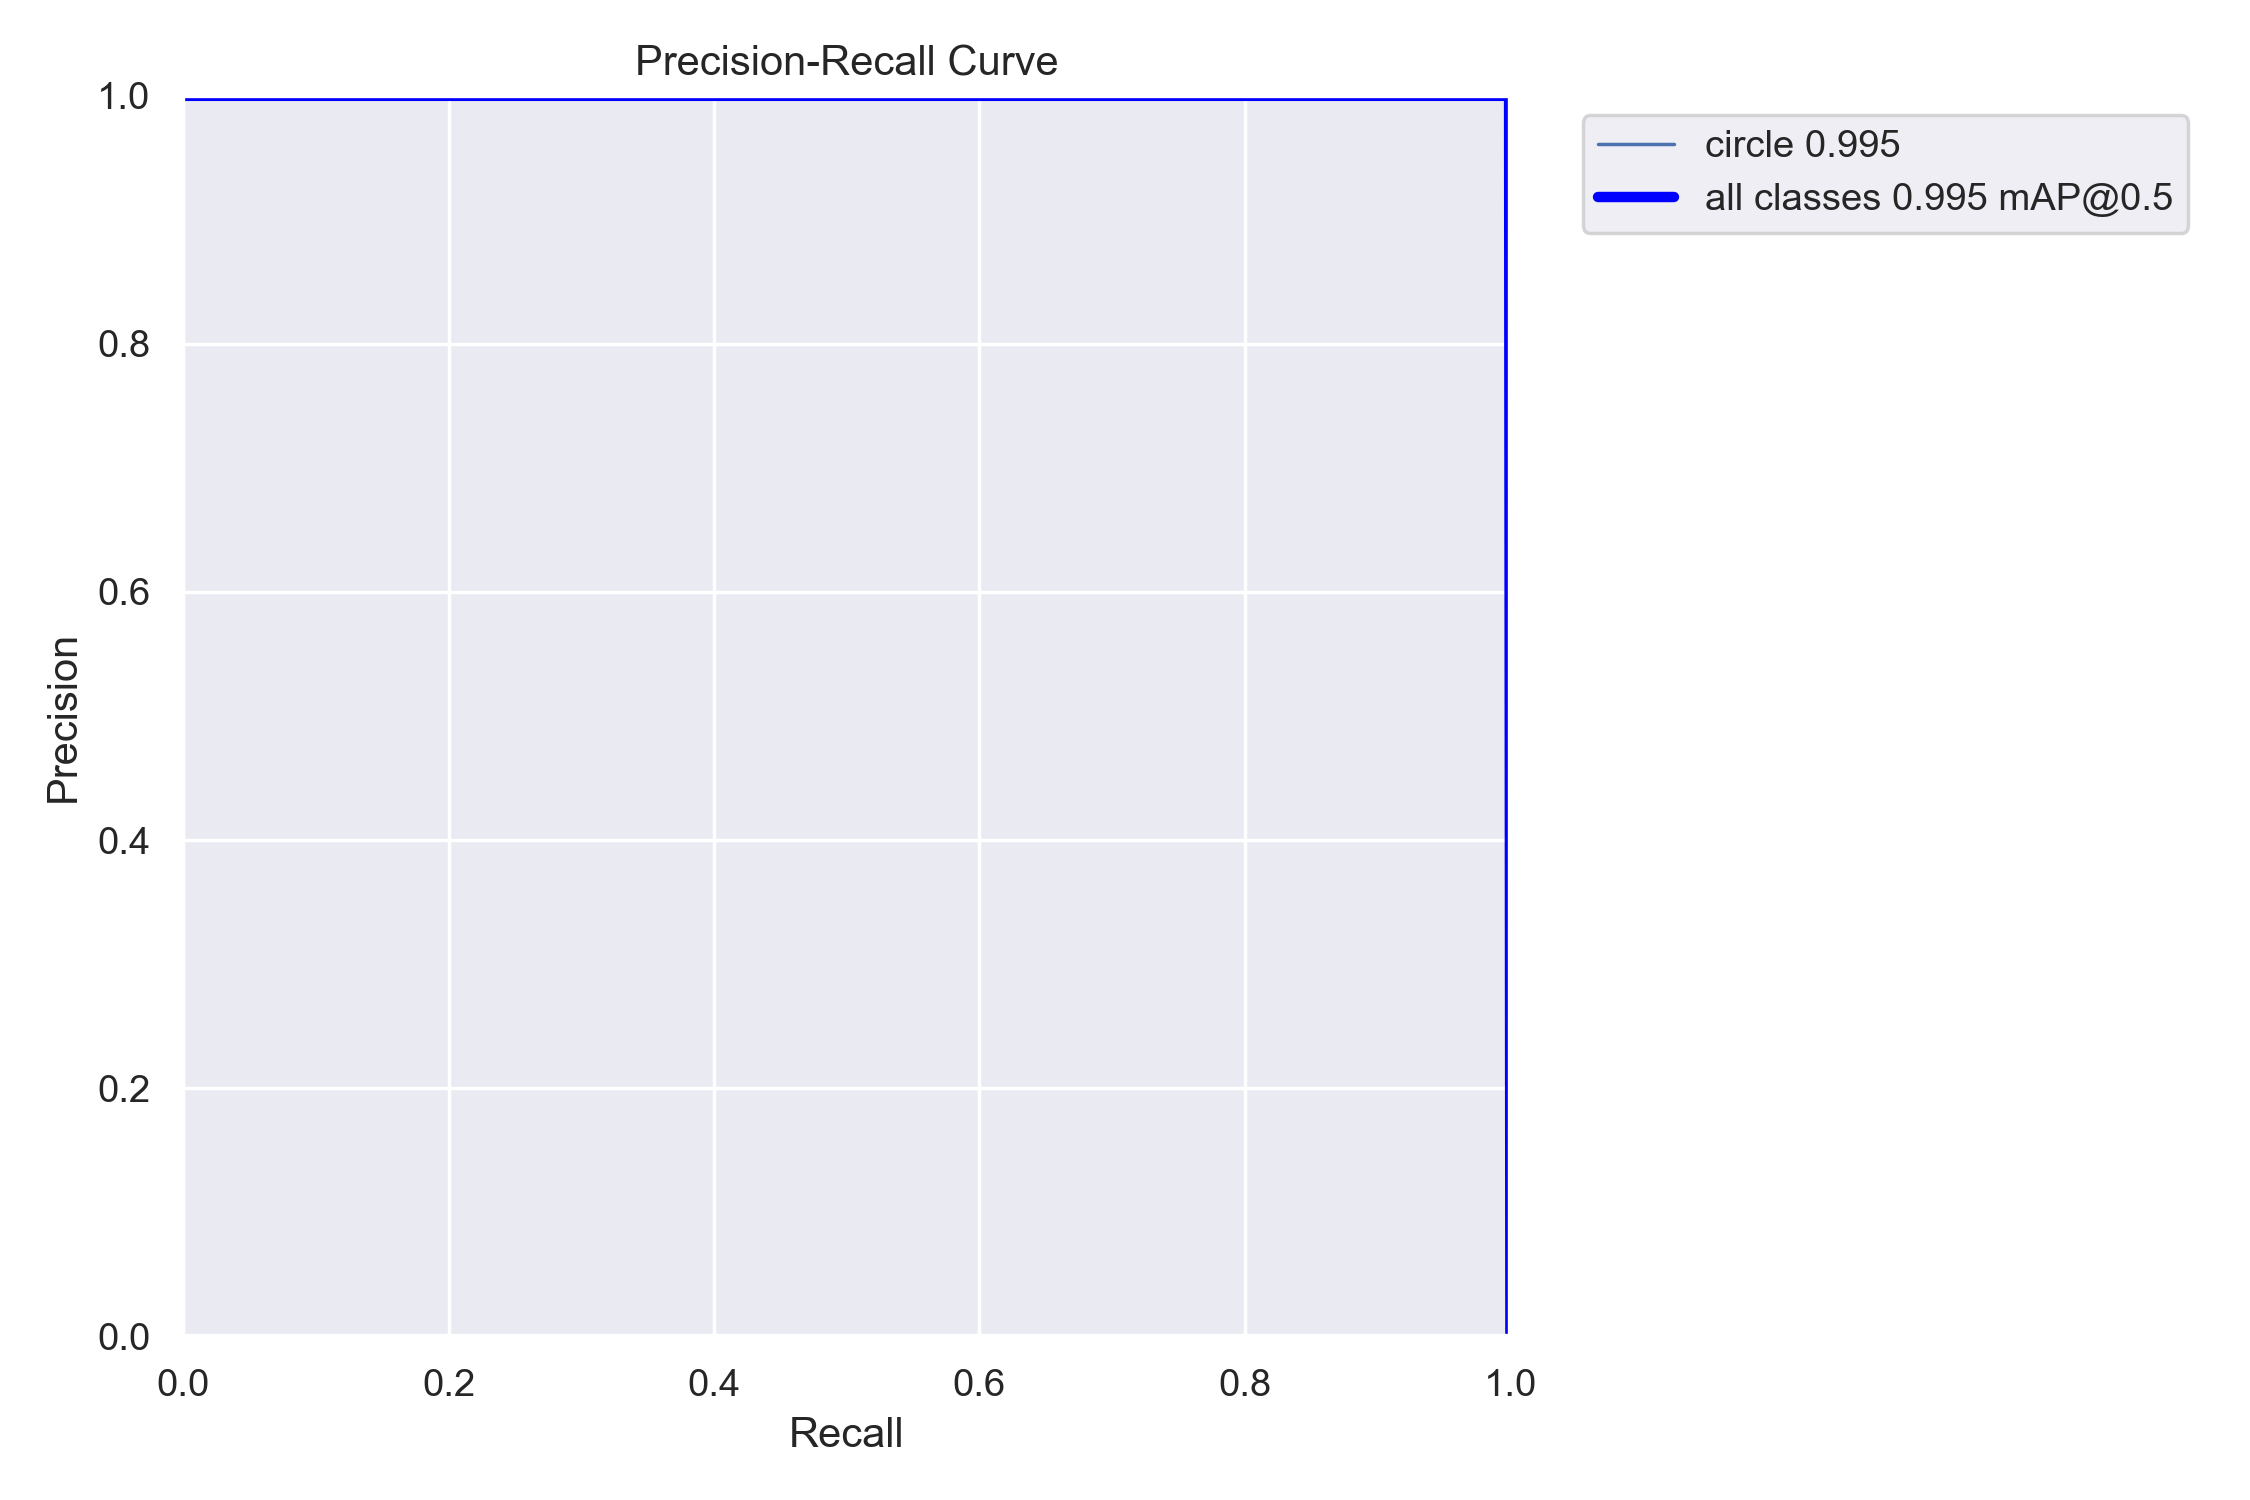

In [15]:
show_image(filename="runs/segment/train/MaskPR_curve.png")

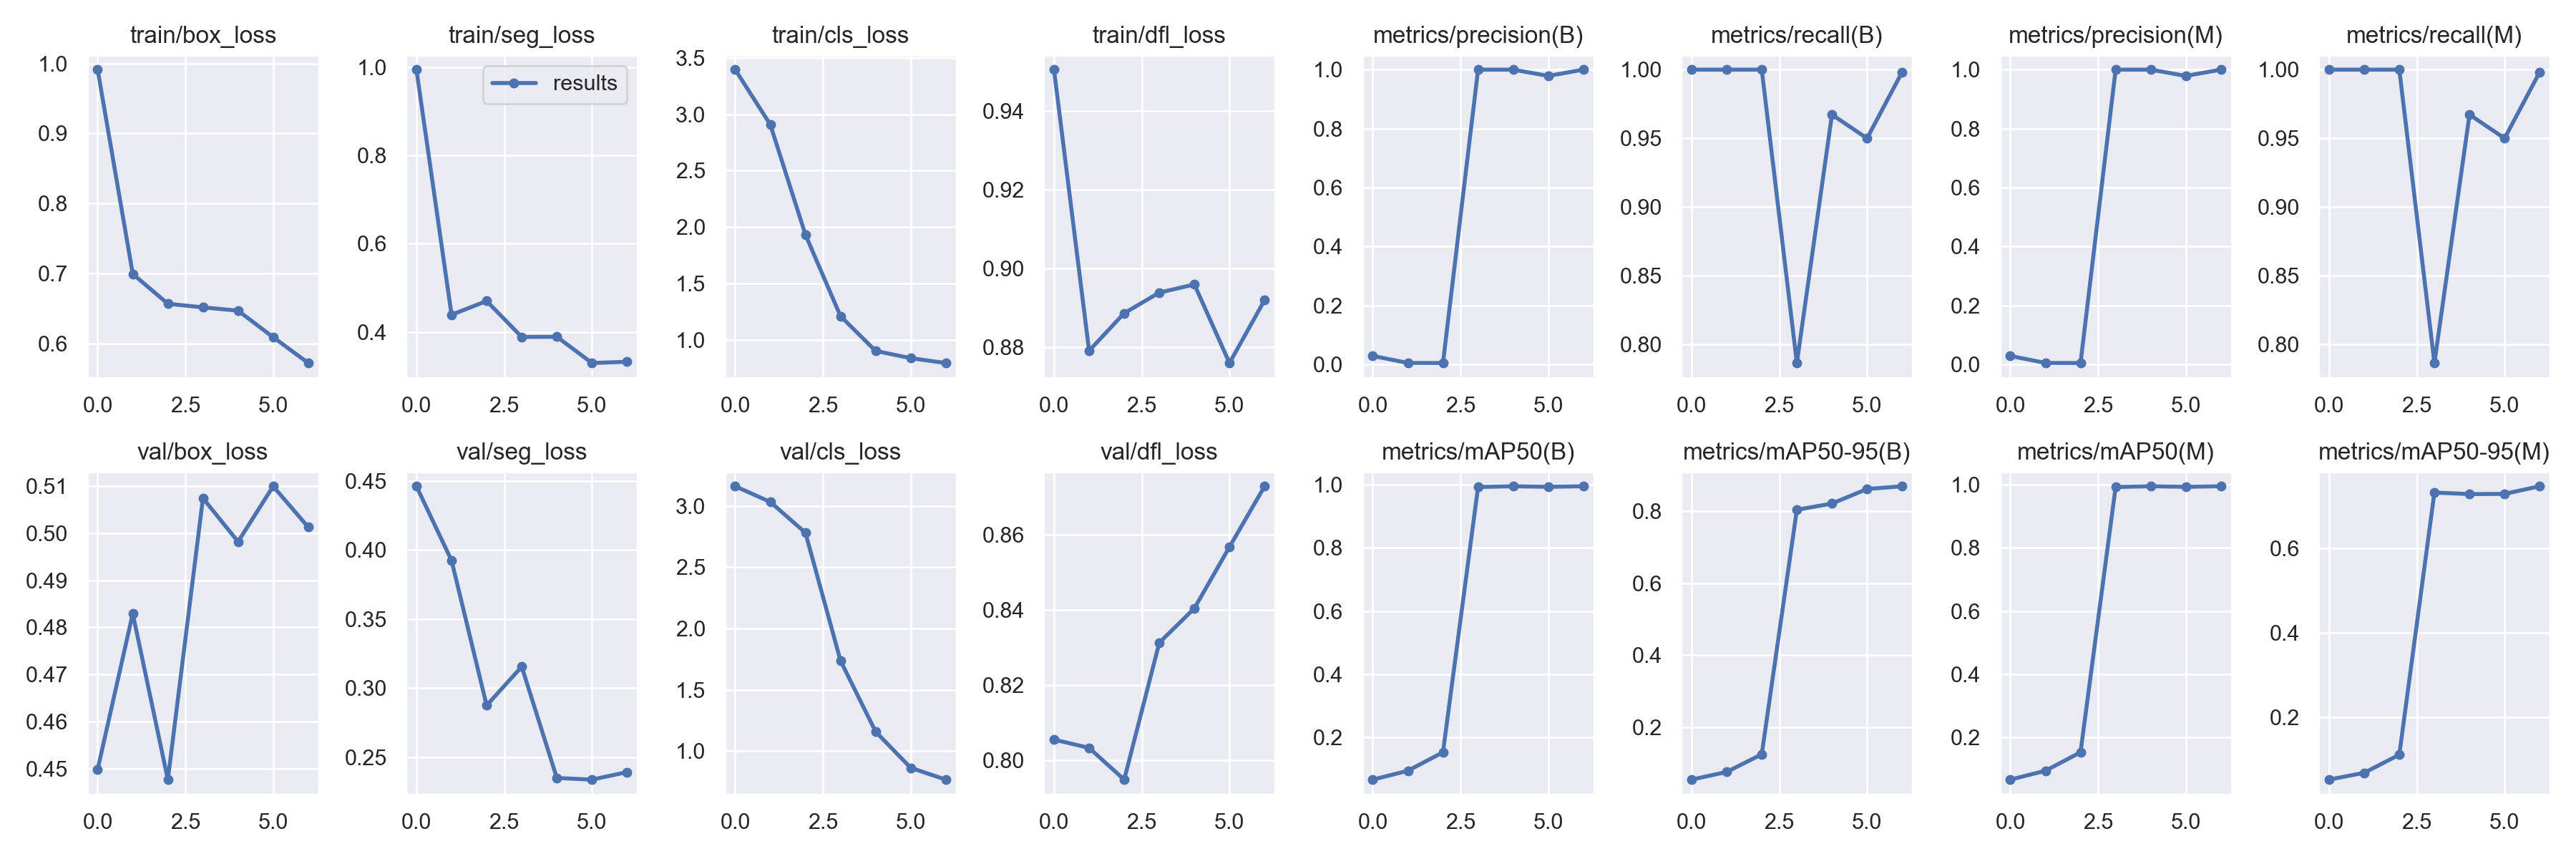

In [16]:
show_image(filename="runs/segment/train/results.png")

In [24]:
my_model = YOLO('runs/segment/train/weights/best.pt')
results = list(my_model('datasets/test/images/img_5.png', conf=0.217))
result = results[0]

Ultralytics YOLOv8.0.38  Python-3.9.13 torch-2.0.0+cpu CPU
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs

image 1/1 C:\Users\areeb\NoteBooks\datasets\test\images\img_5.png: 128x128 1 circle, 43.8ms
Speed: 0.0ms pre-process, 43.8ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)


In [25]:
result

Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
type: <class 'torch.Tensor'>
shape: torch.Size([1, 6])
dtype: torch.float32
 + tensor([[ 94.00000,  66.00000, 116.00000,  87.00000,   0.94829,   0.00000]])Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Masks'> masks
type: <class 'torch.Tensor'>
shape: torch.Size([1, 128, 128])
dtype: torch.float32
 + tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [26]:
result.masks.segments

[array([[    0.82031,      0.5625],
        [     0.8125,     0.57031],
        [     0.8125,     0.70312],
        [    0.82031,     0.71094],
        [    0.82812,     0.71094],
        [    0.84375,     0.72656],
        [    0.84375,     0.73437],
        [    0.85156,     0.74219],
        [    0.89844,     0.74219],
        [    0.90625,     0.73437],
        [    0.92187,     0.73437],
        [    0.92187,     0.72656],
        [    0.92969,     0.71875],
        [     0.9375,     0.71875],
        [    0.94531,     0.71094],
        [    0.95312,     0.71094],
        [    0.96094,     0.70312],
        [    0.96094,     0.60156],
        [    0.92187,      0.5625]], dtype=float32)]

In [27]:
result.masks.masks

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [29]:
import torchvision.transforms as T
T.ToPILImage()(result.masks.masks).show()